In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances_argmin_min, normalized_mutual_info_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
import warnings

warnings.filterwarnings("ignore")

In [4]:
# Загрузка данных и меток
def load_data(dataset_name):
    data_path = f"data/{dataset_name}.csv"
    labels_path = f"data/{dataset_name}-labels.csv"

    X = pd.read_csv(data_path, header=None, delim_whitespace=True).values
    labels = pd.read_csv(labels_path, header=None, delim_whitespace=True).values.flatten()  # преобразуем в одномерный массив
    return X, labels

In [5]:
# Функция для расчета локальной плотности
def local_density(X, d_c):
    n = X.shape[0]
    density = np.zeros(n)
    for i in range(n):
        dist = np.linalg.norm(X[i] - X, axis=1)  # Расстояния до всех других точек
        density[i] = np.sum(dist < d_c)  # Плотность определяется количеством точек в радиусе d_c
    return density

In [6]:
# Функция для расчета минимального расстояния до более плотной точки
def min_distance_to_more_dense(X, density, d_c):
    n = X.shape[0]
    min_dist = np.zeros(n)
    for i in range(n):
        dist = np.linalg.norm(X[i] - X, axis=1)
        more_dense_points = np.where(density > density[i])[0]  # Точки с большей плотностью
        if more_dense_points.size > 0:
            min_dist[i] = np.min(dist[more_dense_points])  # Минимальное расстояние
        else:
            min_dist[i] = np.max(dist)  # Если нет точек с большей плотностью, максимальное расстояние
    return min_dist

In [7]:
# Идентификация центров кластеров
def find_cluster_centers(density, min_dist, num_clusters):
    temp_scores = density * min_dist
    cluster_centers = np.argsort(temp_scores)[-num_clusters:]  # Ищем индексы с наибольшими значениями
    return cluster_centers

In [8]:
# Присвоение точек кластерам
def assign_points_to_clusters(X, density, min_dist, cluster_centers):
    n = X.shape[0]
    labels = np.full(n, -1)
    cluster_id = 1
    for i in range(n):
        # Присваиваем точку к ближайшему кластеру
        nearest_center_idx = pairwise_distances_argmin_min(X[i].reshape(1, -1), X[cluster_centers])[0][0]
        labels[i] = nearest_center_idx + 1  # Увеличиваем идентификатор кластера
    return labels

In [9]:
# Идентификация шума
def identify_noise(density, min_dist, threshold_density=5, threshold_distance=10):
    noise = []
    for i in range(len(density)):
        if density[i] < threshold_density and min_dist[i] > threshold_distance:
            noise.append(i)  # Точки, которые являются шумом
    return noise

In [10]:
# Визуализация кластеров
def plot_clusters(X, labels, noise, true_labels=None):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', label='Clusters')
    if true_labels is not None:
        plt.scatter(X[:, 0], X[:, 1], c=true_labels, cmap='plasma', marker='x', label='True Labels')
    plt.scatter(X[noise, 0], X[noise, 1], color='red', marker='x')  # Шум красным
    plt.title("Distance and Density-Based Clustering")
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

In [11]:
# Оценка кластеризации с помощью NMI
def calculate_nmi(true_labels, predicted_labels):
    return normalized_mutual_info_score(true_labels, predicted_labels)

In [12]:
datasets = [
    "dim032", "dim064", "dim128", "dim256", "u", "s1", "s2", "a1", "a2"
]

Dataset: dim032
Normalized Mutual Information (NMI): 0.8062
Dataset: dim064
Normalized Mutual Information (NMI): 0.7745
Dataset: dim128
Normalized Mutual Information (NMI): 0.7199
Dataset: dim256
Normalized Mutual Information (NMI): 0.7249
Dataset: u
Normalized Mutual Information (NMI): 0.6871


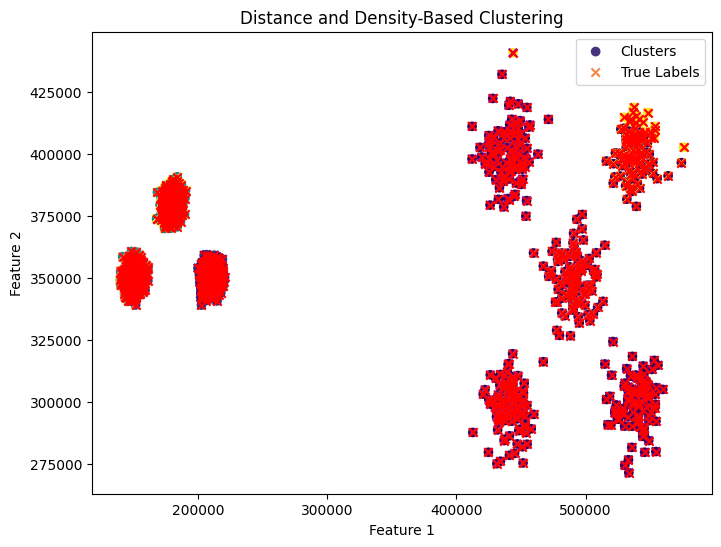

Dataset: s1
Normalized Mutual Information (NMI): 0.5584


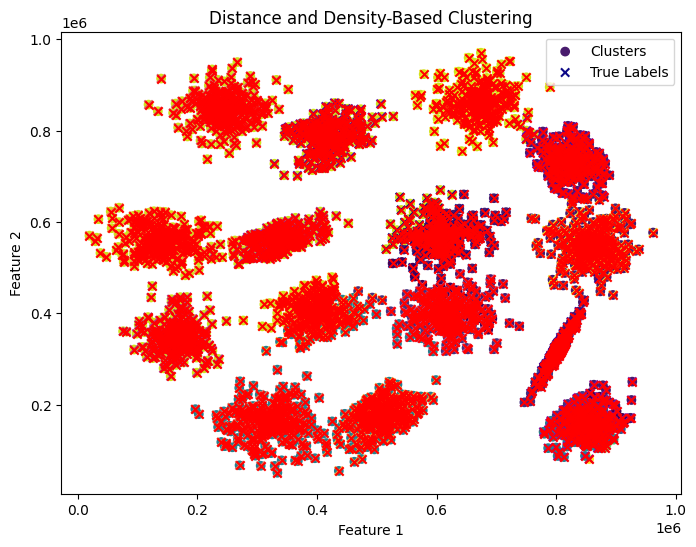

Dataset: s2
Normalized Mutual Information (NMI): 0.6544


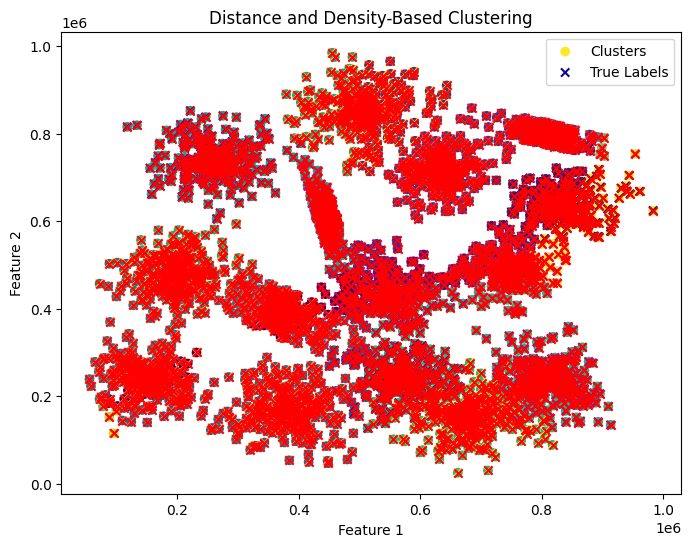

Dataset: a1
Normalized Mutual Information (NMI): 0.6357


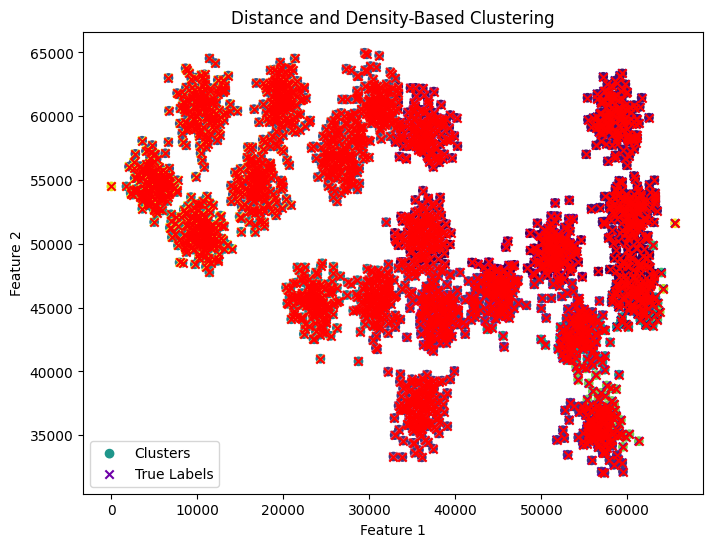

Dataset: a2
Normalized Mutual Information (NMI): 0.6245


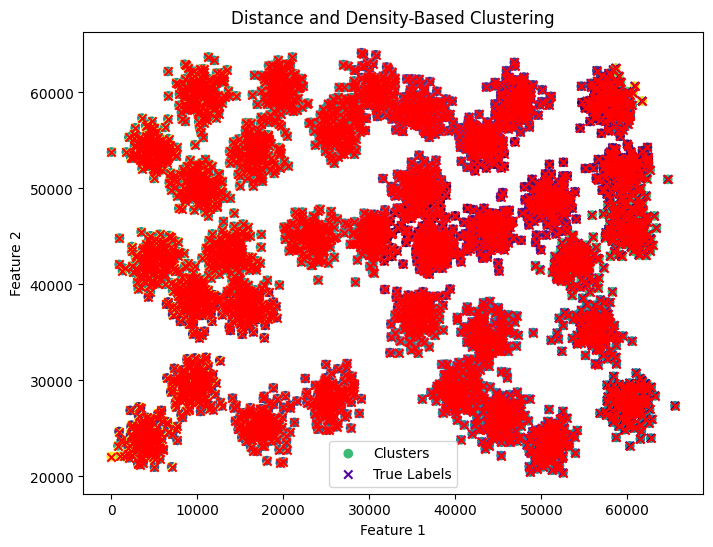

In [13]:
# Перебор датасетов
for dataset_name in datasets:
    X, true_labels = load_data(dataset_name)

    # Нормализуем данные
    if X.shape[1] > 2:  # Если данные имеют больше 2 измерений, выполняем масштабирование
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

    # Используем радиус окрестности для плотности
    d_c = 0.1  # Радиус окрестности
    density = local_density(X, d_c)
    min_dist = min_distance_to_more_dense(X, density, d_c)

    # Идентификация центров кластеров
    num_clusters = len(np.unique(true_labels))  # Определяем количество кластеров на основе меток
    cluster_centers = find_cluster_centers(density, min_dist, num_clusters)

    # Присвоение точек кластерам
    labels_pred = assign_points_to_clusters(X, density, min_dist, cluster_centers)

    # Идентификация шума
    noise = identify_noise(density, min_dist)

    print(f"Dataset: {dataset_name}")

    # Оценка качества кластеризации с помощью NMI
    nmi = calculate_nmi(true_labels, labels_pred)
    print(f"Normalized Mutual Information (NMI): {nmi:.4f}")

    # Визуализация кластеров для двумерных данных
    if X.shape[1] == 2:
        plot_clusters(X, labels_pred, noise, true_labels)


Пробовала подбирать лучшие значения d_c, но результат почти не менялся
В целом про графики можно сказать, что данные хорошо разделяются на несколько плотных кластеров, те есть группы со схожими характеристиками, но между кластерами есть расстояние, те есть четкие границы. Заметим, что почти на всех графиках предсказанные кластеры не полностью совпадают с истинными метками, шумов и выбросов почти нет, можем сделать вывод, что алгоритм хорошо выделяет значимые точки.

# Дополнительно

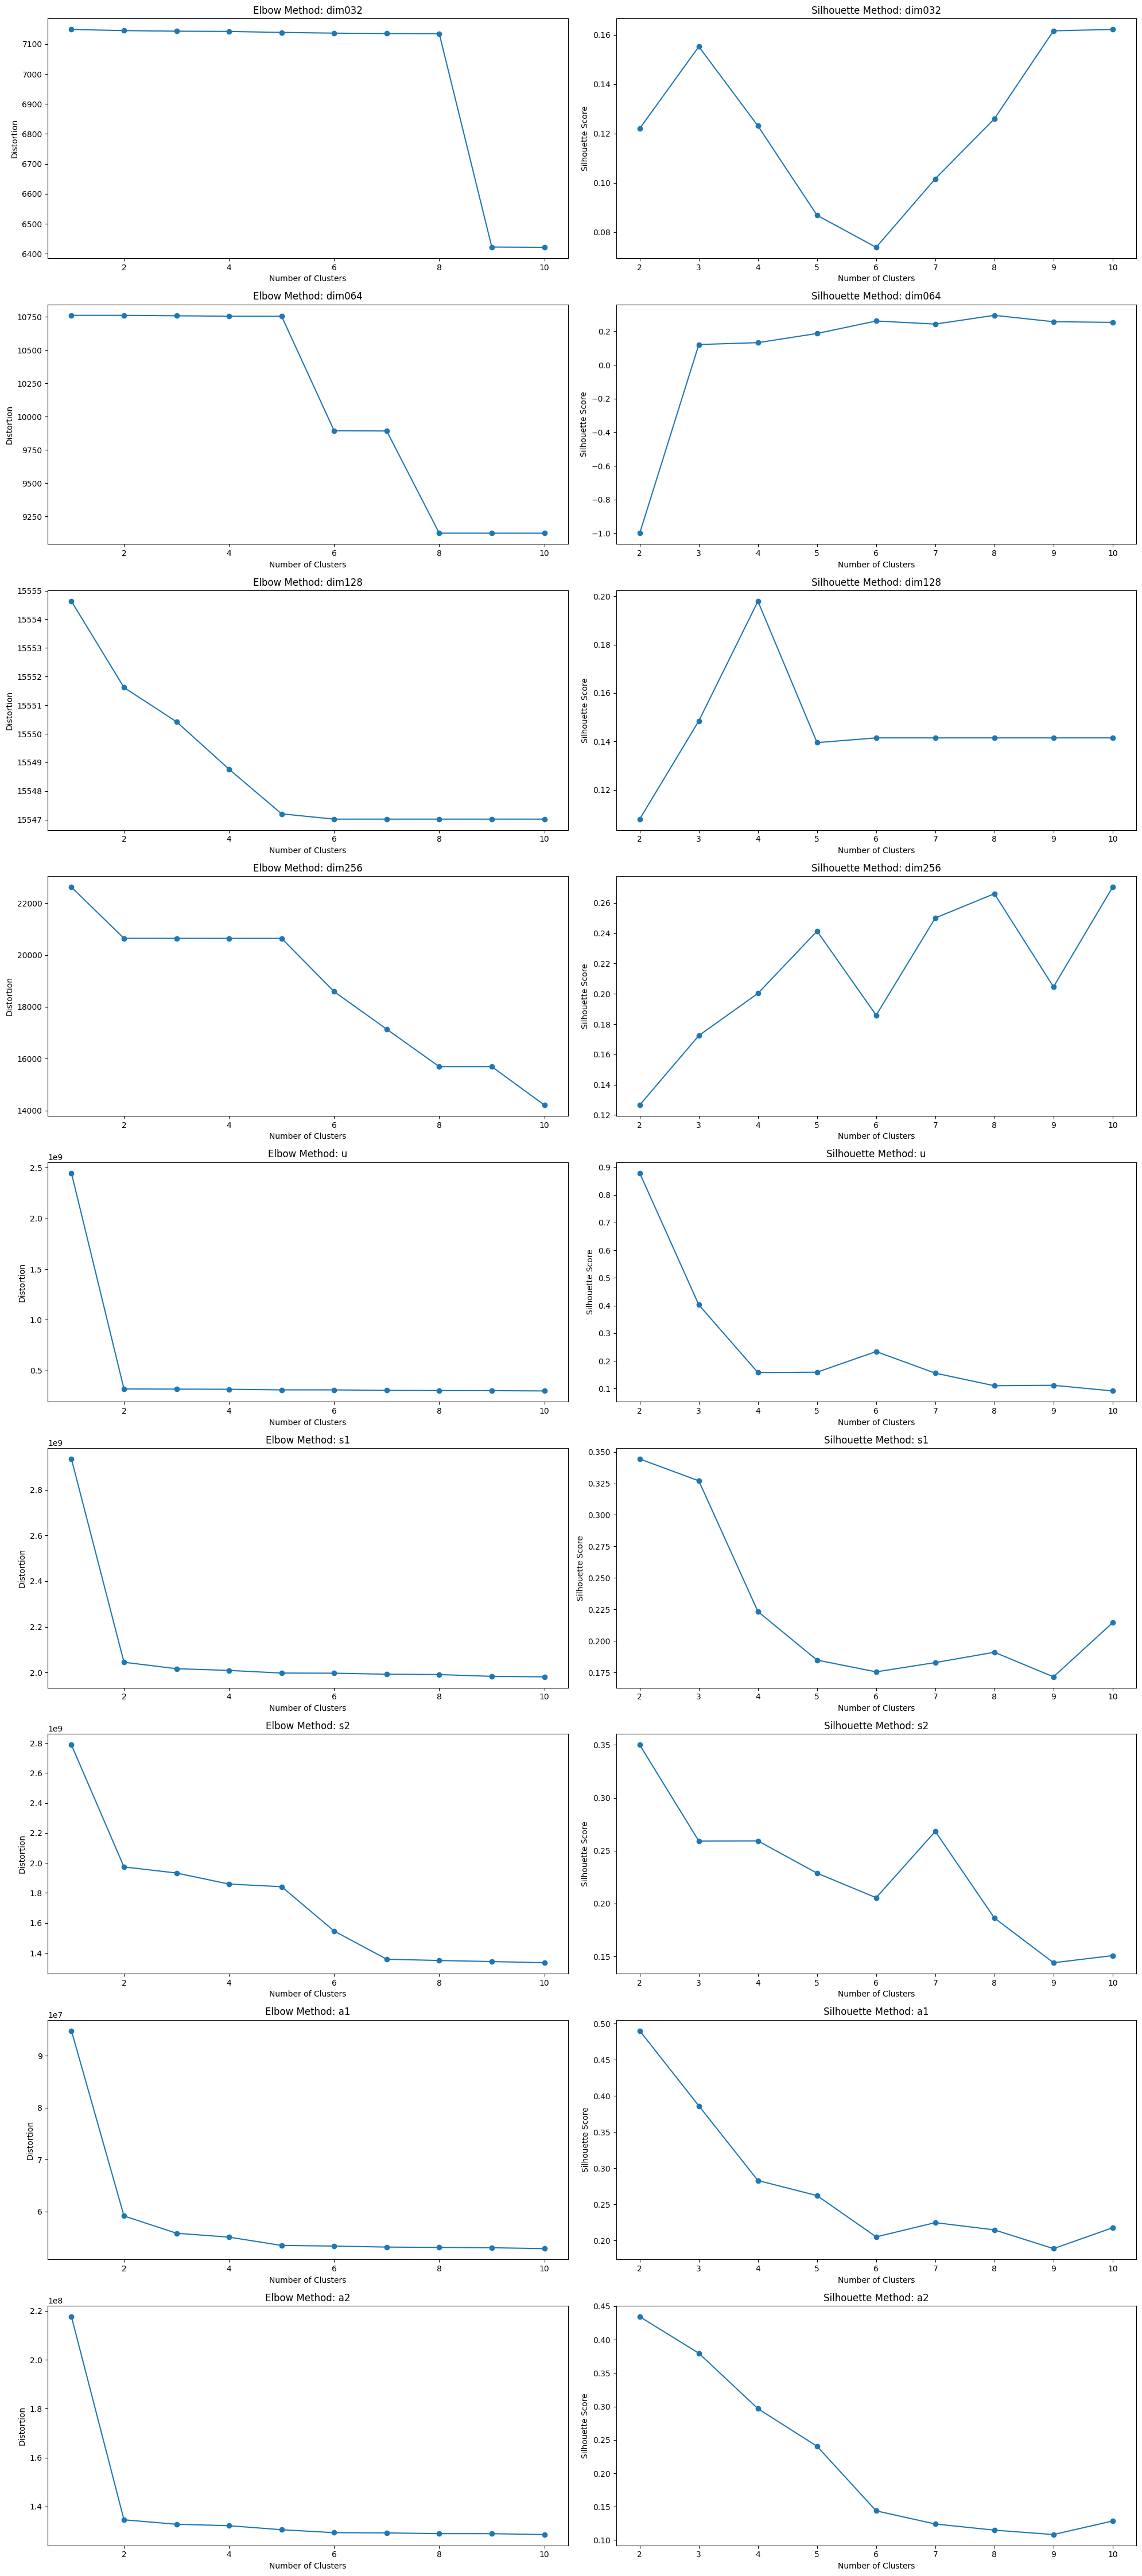

In [35]:
from sklearn.metrics import silhouette_score


# Метод локтя
def elbow_method(X, ax, dataset_name, max_clusters=10):
    distortions = []
    for k in range(1, max_clusters+1):
        density = local_density(X, 0.1)
        min_dist = min_distance_to_more_dense(X, density, 0.1)
        cluster_centers = find_cluster_centers(density, min_dist, k)
        labels_pred = assign_points_to_clusters(X, density, min_dist, cluster_centers)

        distortion = np.sum(np.min(pairwise_distances(X, X[cluster_centers]), axis=1))
        distortions.append(distortion)

    ax.plot(range(1, max_clusters+1), distortions, marker='o')
    ax.set_title(f'Elbow Method: {dataset_name}')
    ax.set_xlabel('Number of Clusters')
    ax.set_ylabel('Distortion')

# Силуэтный коэффициент
def silhouette_method(X, ax, dataset_name, max_clusters=10):
    silhouette_scores = []
    for k in range(2, max_clusters+1):  # Силуэт для количества кластеров больше 1
        density = local_density(X, 0.1)
        min_dist = min_distance_to_more_dense(X, density, 0.1)
        cluster_centers = find_cluster_centers(density, min_dist, k)
        labels_pred = assign_points_to_clusters(X, density, min_dist, cluster_centers)

        if len(np.unique(labels_pred)) > 1:  # Проверка, что количество кластеров больше 1
            silhouette_avg = silhouette_score(X, labels_pred)
            silhouette_scores.append(silhouette_avg)
        else:
            silhouette_scores.append(-1)  # Для 1 кластера, возвращаем -1

    ax.plot(range(2, max_clusters+1), silhouette_scores, marker='o')
    ax.set_title(f'Silhouette Method: {dataset_name}')
    ax.set_xlabel('Number of Clusters')
    ax.set_ylabel('Silhouette Score')

datasets = [
    "dim032", "dim064", "dim128", "dim256", "u", "s1", "s2", "a1", "a2"
]

# Настройка графиков
fig, axes = plt.subplots(len(datasets), 2, figsize=(20, len(datasets) * 5))

for i, dataset_name in enumerate(datasets):
    X, true_labels = load_data(dataset_name)

    # Нормализуем данные
    if X.shape[1] > 2:  # Если данные имеют больше 2 измерений, выполняем масштабирование
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

    # Метод локтя
    elbow_method(X, axes[i, 0], dataset_name)

    # Силуэтный коэффициент
    silhouette_method(X, axes[i, 1], dataset_name)

plt.tight_layout()
plt.show()

Метод локтя работает неплохо для датасетов dim032, dim064, dim128, dim256, но вот для остальных результаты не очень хорошие, silhouette method также работает не очень впечатляюще